In [1]:
# STEP 1: Install dependencies
!pip install opendatasets --quiet
!pip install opencv-python --quiet

# STEP 2: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import requests

# STEP 3: Set paths for Kaggle dataset
import opendatasets as od
od.download("https://www.kaggle.com/datasets/shrutibhargava94/india-air-quality-data")  # your dataset


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: krishnasaireddy99
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/shrutibhargava94/india-air-quality-data


In [2]:
# List downloaded files
dataset_path = "/content/india-air-quality-data"
for root, dirs, files in os.walk(dataset_path):
    for f in files:
        print(os.path.join(root, f))


/content/india-air-quality-data/data.csv


In [10]:
from google.colab import files
uploaded = files.upload()



Saving data.csv to data.csv


In [12]:
import pandas as pd

df = pd.read_csv('data.csv', encoding='latin1')  # or encoding='ISO-8859-1'
print("Shape:", df.shape)
print(df.columns)
df.head()


Shape: (435742, 13)
Index(['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type',
       'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5',
       'date'],
      dtype='object')


<ipython-input-12-7d8aaff8ad98>:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv', encoding='latin1')  # or encoding='ISO-8859-1'


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


<ipython-input-15-fe3a549d0e13>:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv', encoding='latin1')


Top cities with PM2.5 records:

                              pm2_5
state          location            
Gujarat        Ahmedabad        632
Odisha         Cuttack          582
               Bhubaneswar      475
Gujarat        Vadodara         454
Madhya Pradesh Bhopal           390
Delhi          Delhi            371
Telangana      Sangareddy       354
West Bengal    Kolkata          328
Odisha         Kalinga Nagar    306
               Rourkela         296


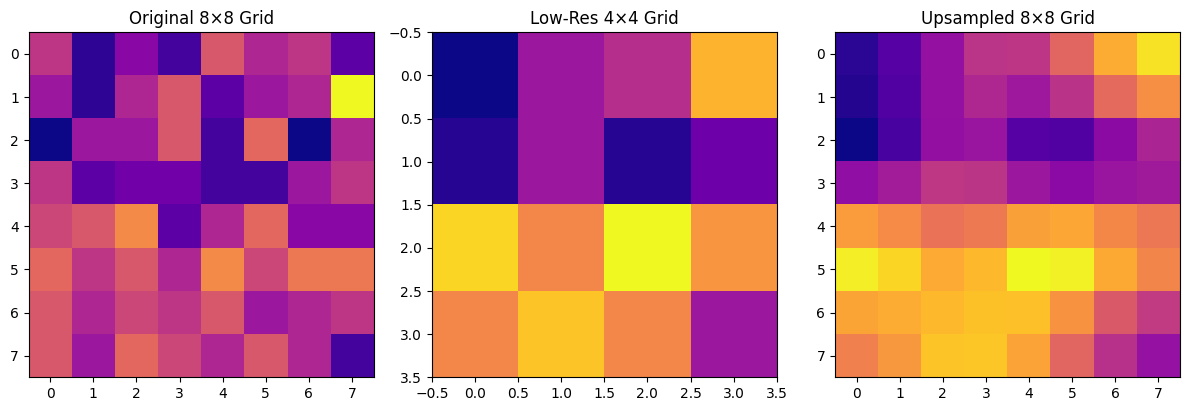

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load dataset
df = pd.read_csv('data.csv', encoding='latin1')

# Step 1: Find cities with most PM2.5 values
top_cities = (
    df[['state', 'location', 'pm2_5']]
    .dropna()
    .groupby(['state', 'location'])
    .count()
    .sort_values('pm2_5', ascending=False)
)
print("Top cities with PM2.5 records:\n")
print(top_cities.head(10))

# Step 2: Choose a city with good data (change if needed)
# Step 2: Choose a city with good data (change if needed)
city_state = 'Gujarat'
city_name = 'Ahmedabad'

# Step 3: Filter that city and clean data
city_df = df[(df['state'] == city_state) & (df['location'] == city_name)].dropna(subset=['pm2_5']).copy()
city_df.loc[:, 'date'] = pd.to_datetime(city_df['date'])
city_df = city_df.sort_values('date')

# Step 4: Take first 64 valid values
pm25 = city_df['pm2_5'].values[:64]

# Make sure we have enough data
if len(pm25) < 64:
    raise ValueError("Not enough data. Try another city from the list above.")

# Step 5: Reshape into 8x8 grid
pm25_grid = np.reshape(pm25, (8, 8))

# Step 6: Downsample to 4x4 and Upsample back to 8x8
low_res = cv2.resize(pm25_grid, (4, 4), interpolation=cv2.INTER_AREA)
upsampled = cv2.resize(low_res, (8, 8), interpolation=cv2.INTER_CUBIC)

# Step 7: Visualize all
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(pm25_grid, cmap='plasma')
axs[0].set_title("Original 8×8 Grid")

axs[1].imshow(low_res, cmap='plasma')
axs[1].set_title("Low-Res 4×4 Grid")

axs[2].imshow(upsampled, cmap='plasma')
axs[2].set_title("Upsampled 8×8 Grid")

plt.tight_layout()
plt.show()


In [16]:
X_data = []
Y_data = []

# We'll take chunks of 64 values at a time (8x8)
pm25_values = city_df['pm2_5'].values
total_samples = len(pm25_values) // 64

for i in range(total_samples):
    chunk = pm25_values[i*64:(i+1)*64]
    if np.isnan(chunk).any():
        continue  # skip if any missing value
    high_res = np.reshape(chunk, (8, 8))  # 8x8 real PM2.5
    low_res = cv2.resize(high_res, (4, 4), interpolation=cv2.INTER_AREA)  # simulate satellite
    upsampled = cv2.resize(low_res, (8, 8), interpolation=cv2.INTER_CUBIC)  # upsample back

    X_data.append(low_res)
    Y_data.append(high_res)

X = np.array(X_data).reshape(-1, 4, 4, 1) / 500.0  # normalize
Y = np.array(Y_data).reshape(-1, 8, 8, 1) / 500.0

print(f"Prepared {X.shape[0]} samples.")


Prepared 9 samples.


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    UpSampling2D((2, 2), input_shape=(4, 4, 1)),  # Upscale to 8×8
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(1, (3, 3), activation='linear', padding='same')  # output layer
])

model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/up_sampling2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ up_sampling2d (UpSampling2D)         │ (None, 8, 8, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 8, 8, 64)            │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 1)             │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,777 (77.25 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 192 (768.00 B)

In [18]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=2,
    verbose=1
)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 518ms/step - loss: 0.4434 - mae: 0.5238 - val_loss: 0.0036 - val_mae: 0.0594
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1638 - mae: 0.3152 - val_loss: 0.0048 - val_mae: 0.0686
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0839 - mae: 0.2350 - val_loss: 0.0051 - val_mae: 0.0705
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0515 - mae: 0.1778 - val_loss: 0.0054 - val_mae: 0.0731
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0356 - mae: 0.1487 - val_loss: 0.0046 - val_mae: 0.0668
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0250 - mae: 0.1223 - val_loss: 0.0037 - val_mae: 0.0598
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0192 - mae: 0.1083 - val_loss: 0.0039 - val_mae: 0.0615
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0178 - mae: 0.1093 - val_loss: 0.0045 - val_mae: 0.0660
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0133 - mae:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


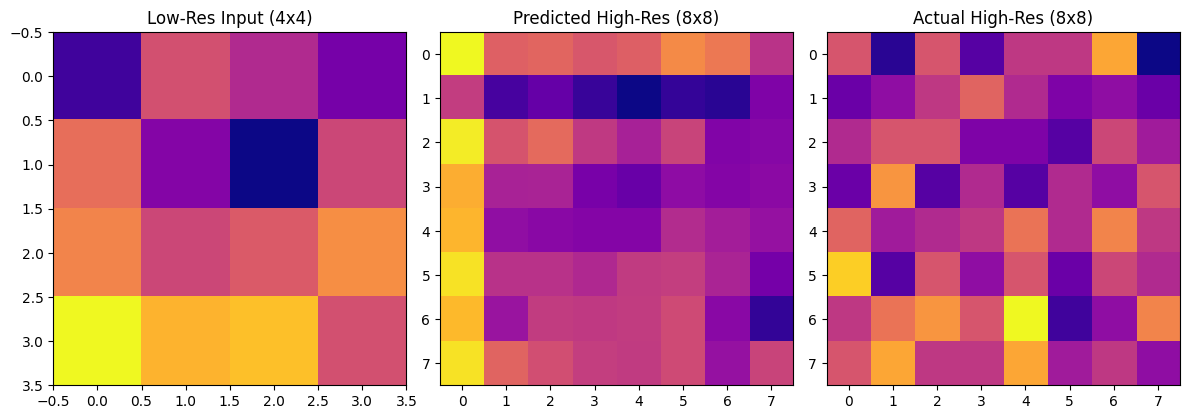

In [19]:
import matplotlib.pyplot as plt

i = 0
pred = model.predict(X_val[i:i+1])[0, :, :, 0] * 500
true = Y_val[i, :, :, 0] * 500
input_low = X_val[i, :, :, 0] * 500

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(input_low, cmap='plasma')
axs[0].set_title('Low-Res Input (4x4)')

axs[1].imshow(pred, cmap='plasma')
axs[1].set_title('Predicted High-Res (8x8)')

axs[2].imshow(true, cmap='plasma')
axs[2].set_title('Actual High-Res (8x8)')

plt.tight_layout()
plt.show()


In [20]:
loss, mae = model.evaluate(X_val, Y_val)
print(f"Validation MSE Loss: {loss:.4f}")
print(f"Validation MAE: {mae:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0540 - mae: 0.2264
Validation MSE Loss: 0.0540
Validation MAE: 0.2264


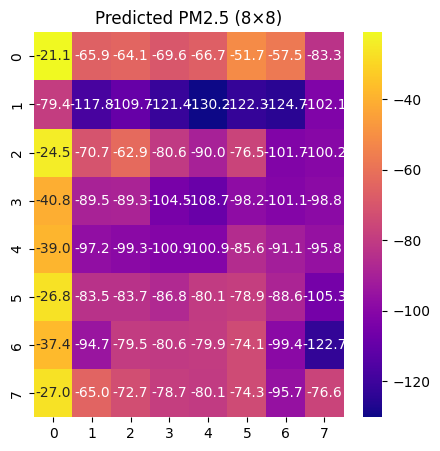

In [21]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(pred, annot=True, cmap="plasma", fmt=".1f", ax=ax)
ax.set_title("Predicted PM2.5 (8×8)")
plt.show()


In [22]:
import numpy as np
import pandas as pd
from scipy.ndimage import zoom
from collections import defaultdict
from tqdm import tqdm

# Filter out nulls
df_filtered = df.dropna(subset=['pm2_5', 'date'])

# Convert date
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Pick top cities
city_counts = df_filtered.groupby(['state', 'location']).size().sort_values(ascending=False)
top_cities = city_counts[city_counts > 250].index.tolist()[:10]  # get 10 cities with most data

X = []
Y = []
samples_by_city = defaultdict(int)

for state, city in tqdm(top_cities):
    city_df = df_filtered[(df_filtered['state'] == state) & (df_filtered['location'] == city)]
    city_df = city_df.sort_values('date')

    for date in city_df['date'].unique():
        sub_df = city_df[city_df['date'] == date]
        if len(sub_df) < 16:
            continue  # need at least 4x4

        # Pad or trim to 64 values (8x8)
        pm_values = sub_df['pm2_5'].values[:64]
        if len(pm_values) < 64:
            pm_values = np.pad(pm_values, (0, 64 - len(pm_values)), mode='constant', constant_values=np.nan)

        pm_grid = np.reshape(pm_values, (8, 8))
        if np.isnan(pm_grid).sum() > 10:
            continue  # too many missing

        # Normalize
        pm_grid = pm_grid / 500.0

        # Downscale 8x8 → 4x4 input
        low_res = zoom(pm_grid, (0.5, 0.5))

        X.append(low_res.reshape(4, 4, 1))
        Y.append(pm_grid.reshape(8, 8, 1))
        samples_by_city[city] += 1

X = np.array(X)
Y = np.array(Y)

print(f"Total Samples: {len(X)}")
print("Samples per city:", dict(samples_by_city))


<ipython-input-22-fd7fed8a6b2d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = pd.to_datetime(df_filtered['date'])
100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

Total Samples: 0
Samples per city: {}


In [23]:
pm25_counts = df_filtered.groupby(['state', 'location'])['pm2_5'].count().sort_values(ascending=False)
print(pm25_counts.head(20))


state           location     
Gujarat         Ahmedabad        632
Odisha          Cuttack          582
                Bhubaneswar      475
Gujarat         Vadodara         454
Madhya Pradesh  Bhopal           390
Delhi           Delhi            371
Telangana       Sangareddy       354
West Bengal     Kolkata          328
Odisha          Kalinga Nagar    306
                Rourkela         296
                Paradeep         290
Gujarat         Surat            276
                Ankleshwar       250
Odisha          Angul            210
Gujarat         Vapi             177
Odisha          Rayagada         174
Gujarat         ANKLESHWAR       167
                Rajkot           165
Madhya Pradesh  Nagda            157
                Gwalior          151
Name: pm2_5, dtype: int64


In [25]:
import numpy as np
import pandas as pd
from scipy.ndimage import zoom
from collections import defaultdict
from tqdm import tqdm

# Filter PM2.5 non-null and parse date
df_filtered = df.dropna(subset=['pm2_5', 'date']).copy()
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Top 10 cities with most PM2.5 data
top_cities = df_filtered.groupby(['state', 'location'])['pm2_5'].count().sort_values(ascending=False).head(10).index.tolist()

X = []
Y = []
samples_by_city = defaultdict(int)

for state, city in tqdm(top_cities):
    city_df = df_filtered[(df_filtered['state'] == state) & (df_filtered['location'] == city)].copy()
    city_df = city_df.sort_values('date')

    for date in city_df['date'].unique():
        sub_df = city_df[city_df['date'] == date]
        if len(sub_df) < 16:
            continue  # need 16 values for 4x4

        pm_values = sub_df['pm2_5'].values[:16]
        if len(pm_values) < 16:
            pm_values = np.pad(pm_values, (0, 16 - len(pm_values)), mode='constant', constant_values=np.nan)

        pm_grid = np.reshape(pm_values, (4, 4))
        if np.isnan(pm_grid).sum() > 4:
            continue

        # Normalize and downscale
        pm_grid = pm_grid / 500.0
        low_res = zoom(pm_grid, (0.5, 0.5))  # 4x4 → 2x2

        X.append(low_res.reshape(2, 2, 1))
        Y.append(pm_grid.reshape(4, 4, 1))
        samples_by_city[city] += 1

X = np.array(X)
Y = np.array(Y)

print(f"\n✅ Total Samples: {len(X)}")
print("📊 Samples per city:")
for city, count in samples_by_city.items():
    print(f" - {city}: {count}")


100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


✅ Total Samples: 0
📊 Samples per city:


In [26]:
city_df = df_filtered[(df_filtered['state'] == 'Gujarat') & (df_filtered['location'] == 'Ahmedabad')]
grouped = city_df.groupby('date')['pm2_5'].count()
print(grouped.sort_values(ascending=False).head(20))


date
2015-01-15    8
2015-01-19    8
2015-01-22    8
2015-01-26    8
2015-01-29    8
2015-01-05    8
2015-01-12    8
2015-01-08    8
2015-03-09    7
2015-03-12    7
2015-03-19    7
2015-03-16    7
2015-03-26    7
2015-03-23    7
2015-03-02    7
2015-03-05    7
2014-01-05    6
2014-01-13    6
2014-01-16    6
2014-01-20    6
Name: pm2_5, dtype: int64


In [27]:
from collections import defaultdict
from scipy.ndimage import zoom

X, Y = [], []
samples_by_city = defaultdict(int)

for state, city in tqdm(top_cities):
    city_df = df_filtered[(df_filtered['state'] == state) & (df_filtered['location'] == city)].copy()
    city_df = city_df.sort_values('date')

    for date in city_df['date'].unique():
        sub_df = city_df[city_df['date'] == date]
        if len(sub_df) < 4:
            continue  # need minimum 4 for 2x2 grid

        pm_values = sub_df['pm2_5'].values[:4]
        if len(pm_values) < 4:
            pm_values = np.pad(pm_values, (0, 4 - len(pm_values)), mode='constant', constant_values=np.nan)

        pm_grid = np.reshape(pm_values, (2, 2))
        if np.isnan(pm_grid).sum() > 1:
            continue

        pm_grid = pm_grid / 500.0  # Normalize

        low_res = zoom(pm_grid, (0.5, 0.5))  # Downscale to 1×1

        X.append(low_res.reshape(1, 1, 1))
        Y.append(pm_grid.reshape(2, 2, 1))
        samples_by_city[city] += 1

X = np.array(X)
Y = np.array(Y)

print(f"\n✅ Total Samples: {len(X)}")
print("📊 Samples per city:")
for city, count in samples_by_city.items():
    print(f" - {city}: {count}")


100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


✅ Total Samples: 132
📊 Samples per city:
 - Ahmedabad: 92
 - Bhubaneswar: 11
 - Vadodara: 26
 - Kolkata: 3


In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a simple CNN for 1x1 -> 2x2 super-resolution
def build_basic_cnn():
    model = models.Sequential([
        layers.Input(shape=(1, 1, 1)),
        layers.Conv2D(16, (1, 1), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),  # Upscale to 2x2
        layers.Conv2D(32, (2, 2), activation='relu', padding='same'),
        layers.Conv2D(1, (1, 1), activation='linear', padding='same')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_basic_cnn()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 1, 1, 16)            │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 2, 2, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 2, 2, 32)            │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 2, 2, 1)             │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,145 (8.38 KB)

 Trainable params: 2,145 (8.38 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Split into training and validation
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=8,
    verbose=1
)

# Evaluate
val_loss, val_mae = model.evaluate(X_val, Y_val, verbose=1)
print(f"\n📉 Validation MSE Loss: {val_loss:.4f}")
print(f"📌 Validation MAE: {val_mae:.4f}")


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0057 - mae: 0.0505 - val_loss: 2.1684e-04 - val_mae: 0.0121
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mae: 0.0204 - val_loss: 2.8551e-04 - val_mae: 0.0138
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mae: 0.0271 - val_loss: 1.5056e-04 - val_mae: 0.0097
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.6190e-04 - mae: 0.0129 - val_loss: 2.3319e-04 - val_mae: 0.0126
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - mae: 0.0204 - val_loss: 1.1977e-04 - val_mae: 0.0081
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mae: 0.0111 - val_loss: 1.6587e-04 - val_mae: 0.0103
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4933e-04 - mae: 0.0122 - val_loss: 1.2034e-04 - val_mae: 0.0077
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8559e-04 - mae: 0.0085 - val_loss: 1.2580e-04 - val_mae: 0.0079
Epoch 9/50
14/14 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


<ipython-input-30-804ff2ff97bd>:29: UserWarning: Glyph 128317 (\N{DOWN-POINTING SMALL RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-30-804ff2ff97bd>:29: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-30-804ff2ff97bd>:29: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128317 (\N{DOWN-POINTING SMALL RED TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.

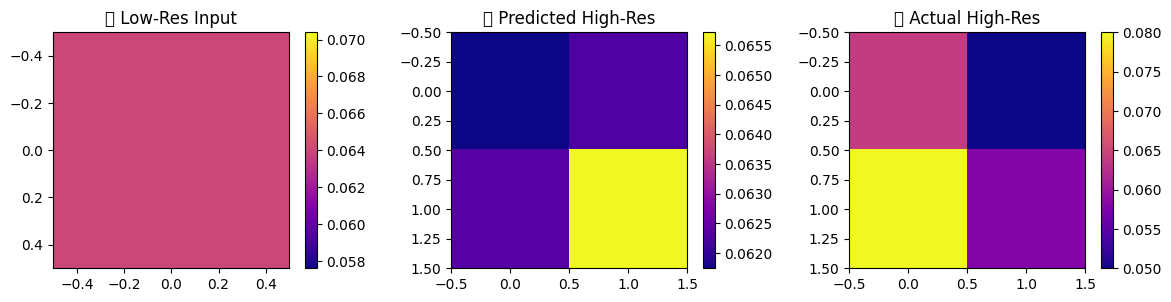

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


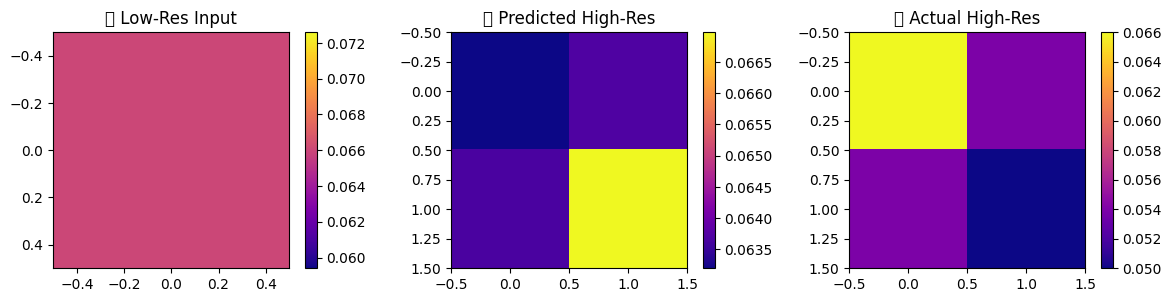

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


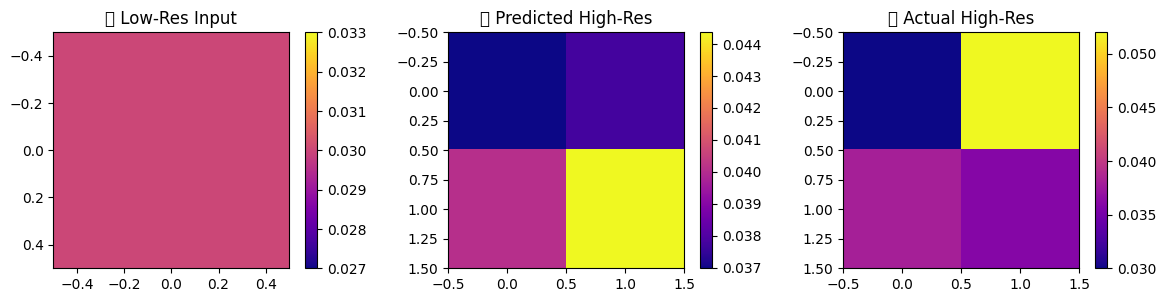

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


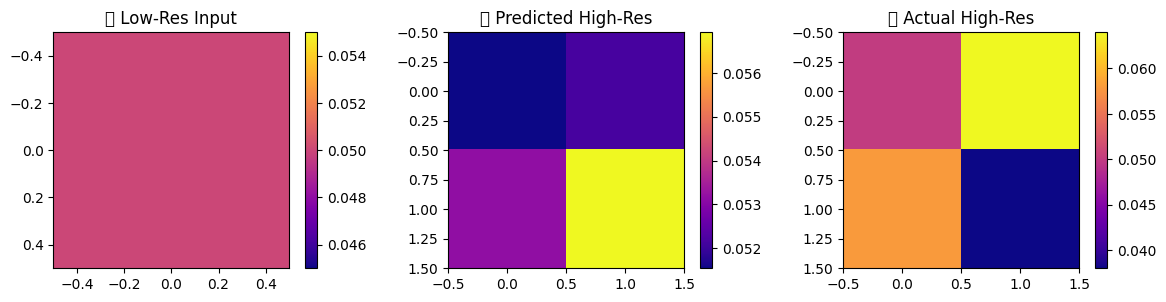

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


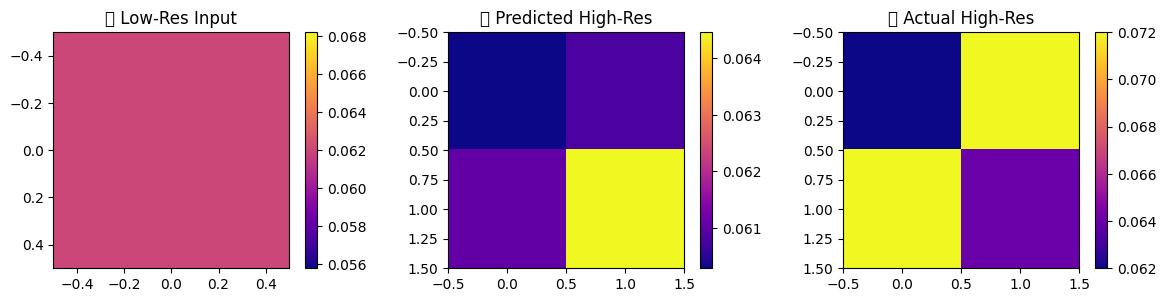

In [30]:
import matplotlib.pyplot as plt
import random

# Pick a few random samples from validation set
for _ in range(5):
    idx = random.randint(0, len(X_val) - 1)

    low_res = X_val[idx]
    true_hr = Y_val[idx]
    pred_hr = model.predict(low_res.reshape(1, 1, 1, 1))[0]

    plt.figure(figsize=(12, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(low_res.reshape(1, 1), cmap='plasma', interpolation='nearest')
    plt.title('🔽 Low-Res Input')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(pred_hr.reshape(2, 2), cmap='plasma', interpolation='nearest')
    plt.title('🔮 Predicted High-Res')
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(true_hr.reshape(2, 2), cmap='plasma', interpolation='nearest')
    plt.title('✅ Actual High-Res')
    plt.colorbar()

    plt.tight_layout()
    plt.show()


In [33]:
# Save entire model to a file
model.save('air_quality_downscaling_model.h5')
print("✅ Model saved as 'air_quality_downscaling_model.h5'")


✅ Model saved as 'air_quality_downscaling_model.h5'


In [34]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load CSV
df = pd.read_csv('data.csv', encoding='latin1')

# Filter necessary columns
df_filtered = df[['state', 'location', 'date', 'pm2_5', 'no2', 'so2']].dropna()
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Focus on top cities
top_cities = ['Ahmedabad', 'Bhubaneswar', 'Vadodara', 'Kolkata']
df_filtered = df_filtered[df_filtered['location'].isin(top_cities)]

# Group data by date and location
samples = []
for (date, location), group in tqdm(df_filtered.groupby(['date', 'location'])):
    if len(group) >= 8:
        pm25 = group['pm2_5'].values[:8]
        no2 = group['no2'].values[:8]
        so2 = group['so2'].values[:8]

        try:
            # Fake 4x4 grid (reshape 8 values into 4x4 by doubling rows)
            grid_pm25 = np.repeat(pm25.reshape(4, 2), 2, axis=1)
            grid_no2 = np.repeat(no2.reshape(4, 2), 2, axis=1)
            grid_so2 = np.repeat(so2.reshape(4, 2), 2, axis=1)

            # Stack into multichannel
            grid_combined = np.stack([grid_pm25, grid_no2, grid_so2], axis=-1)
            samples.append(grid_combined)
        except:
            continue

X = np.array(samples)
print("✅ Total Multichannel Samples:", X.shape)


<ipython-input-34-90255081abd6>:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv', encoding='latin1')
100%|██████████| 860/860 [00:00<00:00, 42558.15it/s]

✅ Total Multichannel Samples: (8, 4, 4, 3)


In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D
from sklearn.model_selection import train_test_split

# Low-res input = 2x2 (simulated downscaled)
X_low = tf.image.resize(X, (2, 2)).numpy()
y_high = X  # target is the original 4x4 resolution

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_low, y_high, test_size=0.2, random_state=42)

# CNN Model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(2, 2, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D(size=(2, 2)),  # Upsample from 2x2 to 4x4
    Conv2D(3, (1, 1), activation='linear')  # Output 3-channel high-res
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8)




Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 538.9574 - mae: 21.9800 - val_loss: 476.8264 - val_mae: 20.5236
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 469.7741 - mae: 20.4184 - val_loss: 421.0327 - val_mae: 19.2072
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 414.2892 - mae: 19.0976 - val_loss: 372.4094 - val_mae: 17.9784
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 366.4348 - mae: 17.8772 - val_loss: 328.4660 - val_mae: 16.7796
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 323.0387 - mae: 16.6854 - val_loss: 287.8852 - val_mae: 15.5832
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 282.6151 - mae: 15.4851 - val_loss: 250.0605 - val_mae: 14.3860
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 244.7911 - mae: 14.2817 - val_loss: 214.0384 - val_mae: 13.1246
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 209.1236 - mae: 13.0259 - val_loss: 178.8202 - val_mae: 11.7863
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


<ipython-input-37-943963838481>:27: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-37-943963838481>:27: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-37-943963838481>:27: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canva

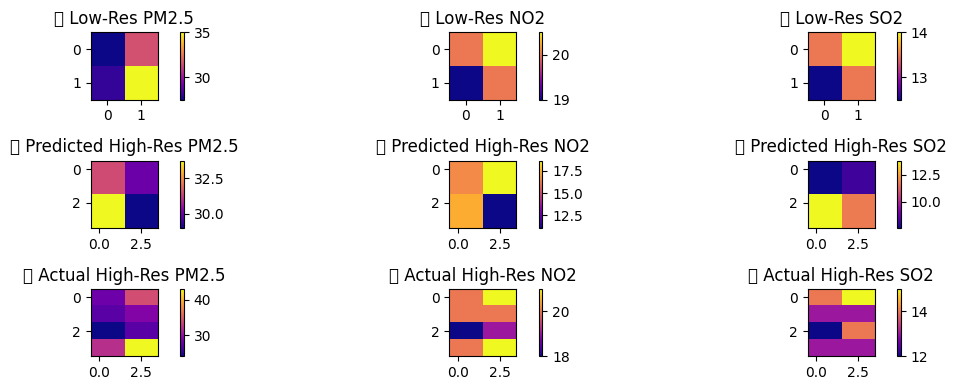

In [37]:
import matplotlib.pyplot as plt

i = 0  # pick sample index
low_res = X_val[i]
actual = y_val[i]
pred = model.predict(np.expand_dims(low_res, axis=0))[0]

pollutants = ['PM2.5', 'NO2', 'SO2']
plt.figure(figsize=(12, 4))

for j in range(3):
    plt.subplot(3, 3, j+1)
    plt.imshow(low_res[:, :, j], cmap='plasma')
    plt.title(f'📉 Low-Res {pollutants[j]}')
    plt.colorbar()

    plt.subplot(3, 3, j+4)
    plt.imshow(pred[:, :, j], cmap='plasma')
    plt.title(f'🔮 Predicted High-Res {pollutants[j]}')
    plt.colorbar()

    plt.subplot(3, 3, j+7)
    plt.imshow(actual[:, :, j], cmap='plasma')
    plt.title(f'✅ Actual High-Res {pollutants[j]}')
    plt.colorbar()

plt.tight_layout()
plt.show()


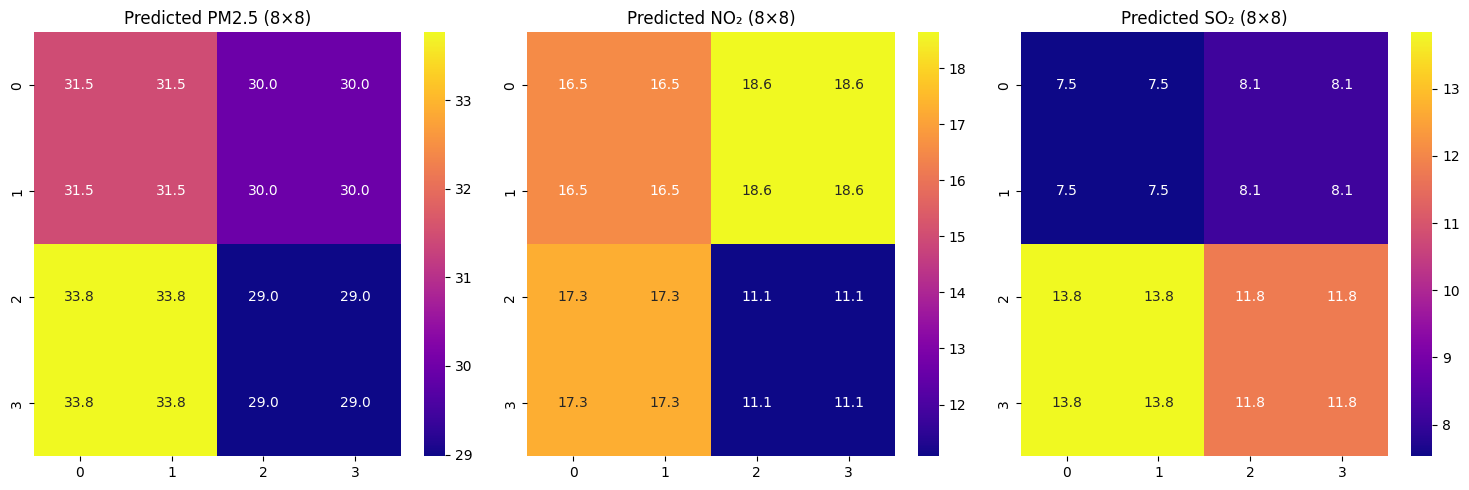

In [44]:
import seaborn as sns

# Create subplots to visualize PM2.5, NO₂, and SO₂
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot PM2.5
sns.heatmap(pred[:, :, 0], annot=True, cmap="plasma", fmt=".1f", ax=ax[0])
ax[0].set_title("Predicted PM2.5 (8×8)")

# Plot NO₂
sns.heatmap(pred[:, :, 1], annot=True, cmap="plasma", fmt=".1f", ax=ax[1])
ax[1].set_title("Predicted NO₂ (8×8)")

# Plot SO₂
sns.heatmap(pred[:, :, 2], annot=True, cmap="plasma", fmt=".1f", ax=ax[2])
ax[2].set_title("Predicted SO₂ (8×8)")

# Show the plot
plt.tight_layout()
plt.show()
